<a href="https://colab.research.google.com/github/raffeekk/ML25/blob/main/homework/HW2_GorbunenkoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическое задание 2

## Общая информация

Дата выдачи: 11.10.2016

Срок сдачи: 24.10.2016 23:59MSK

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW2_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW2_IvanovII.ipynb*). Далее отправьте этот файл на enkalaidin@gmail.com .

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [3]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

head: cannot open 'Train_rev1.csv' for reading: No such file or directory


In [11]:
# Загрузка данных
df = pd.read_csv("https://media.githubusercontent.com/media/raffeekk/ML25/refs/heads/main/Train_rev1.csv", sep=',')
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк датасета:")
print(df.head())

Размер датасета: (244768, 12)

Первые 5 строк датасета:
         Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          N

В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

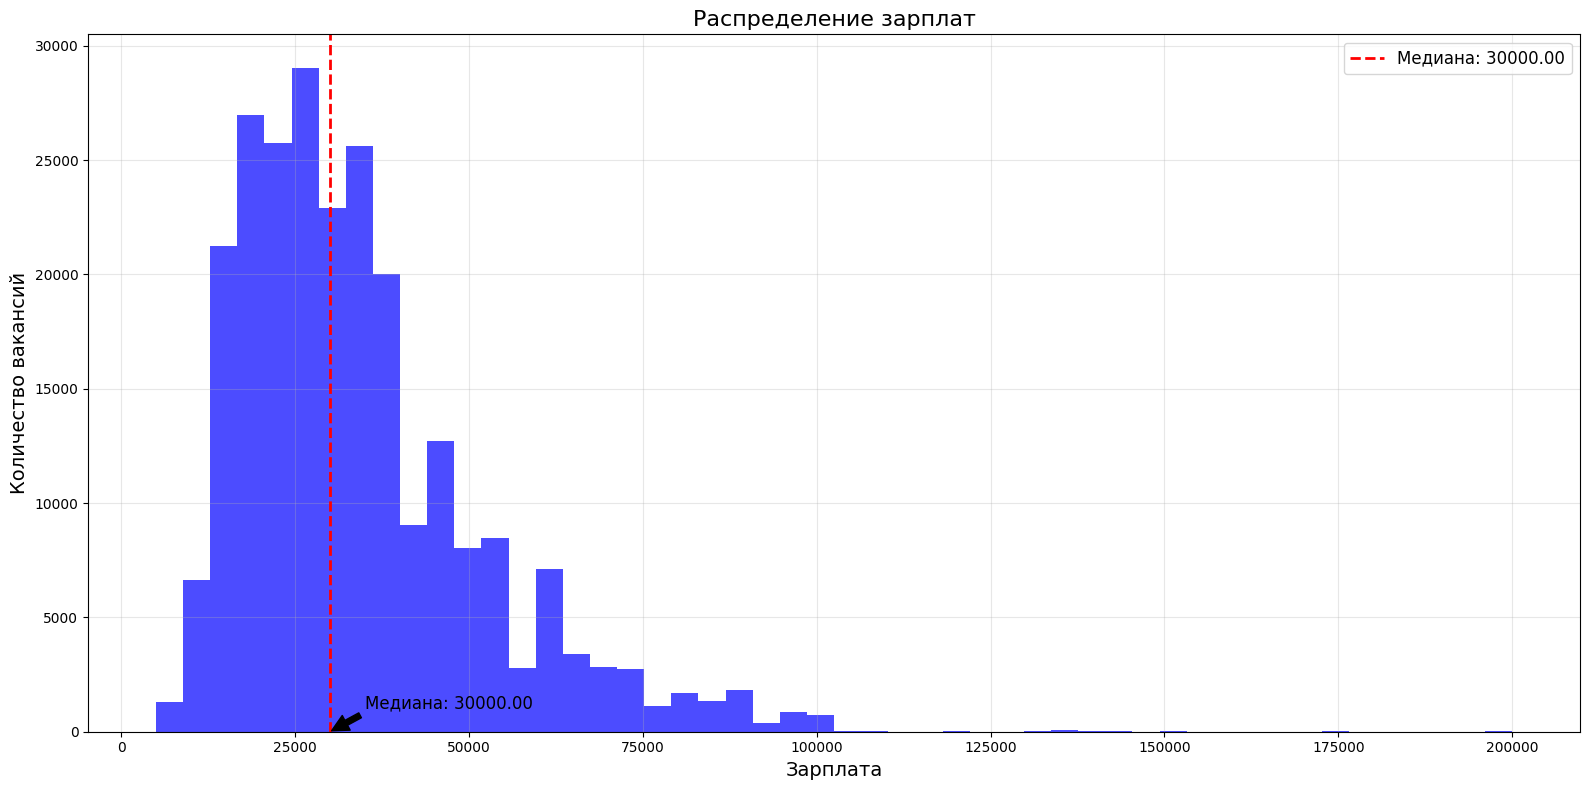


Распределение классов после бинаризации:
SalaryNormalized
0    0.515545
1    0.484455
Name: proportion, dtype: float64


In [12]:
# Построение гистограммы зарплат
plt.figure(figsize=(16, 8))
median = np.median(df['SalaryNormalized'])

# Строим гистограмму
plt.hist(df['SalaryNormalized'], bins=50, alpha=0.7, color='blue')
plt.axvline(median, color='red', linestyle='--', linewidth=2, label=f'Медиана: {median:.2f}')

# Настройка осей и сетки
plt.xlabel('Зарплата', fontsize=14)
plt.ylabel('Количество вакансий', fontsize=14)
plt.title('Распределение зарплат', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Добавляем аннотацию с медианой
plt.annotate(f'Медиана: {median:.2f}',
            xy=(median, 0),
            xytext=(median + 5000, 1000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12)

plt.tight_layout()
plt.show()

# Разделение на высокую и низкую зарплату по медиане
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)

# Проверка баланса классов
print("\nРаспределение классов после бинаризации:")
print(df['SalaryNormalized'].value_counts(normalize=True))

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [14]:
median = np.median(df['SalaryNormalized'])
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [15]:
# Your code here
X = df.drop('SalaryNormalized', axis=1)
y = df['SalaryNormalized']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер контрольной выборки: {X_test.shape}")



Размер обучающей выборки: (171337, 10)
Размер контрольной выборки: (73431, 10)


## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [16]:
# Your code here
# Объединяем все признаки в одну строку
X_train_text = X_train.apply(lambda x: ' '.join(x.astype(str)), axis=1)
X_test_text = X_test.apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Создаем и обучаем CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_text)
X_test_vectorized = vectorizer.transform(X_test_text)

#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [ ]:
# Your code here
from google.colab import files
# Логистическая регрессия из sklearn
lr_sklearn = LogisticRegression(random_state=42)
lr_sklearn.fit(X_train_vectorized, y_train)

# Для Vowpal Wabbit нужно сохранить данные в формат VW
# Создаем файлы для VW
def save_to_vw_format(X, y, filename):
    with open(filename, 'w') as f:
        for i in range(len(X)):
            features = ' '.join([f"{j+1}:{val}" for j, val in enumerate(X[i])])
            f.write(f"{y[i]} | {features}\n")

save_to_vw_format(X_train_vectorized.toarray(), y_train, 'train.vw')
save_to_vw_format(X_test_vectorized.toarray(), y_test, 'test.vw')
files.download('train.vw')
files.download('test.vw')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [1]:
# Your code here
# Для sklearn модели
y_pred_sklearn = lr_sklearn.predict(X_test_vectorized)
y_prob_sklearn = lr_sklearn.predict_proba(X_test_vectorized)[:, 1]

print("\nМетрики для sklearn модели:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_sklearn):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_sklearn):.4f}")
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_sklearn))

NameError: name 'lr_sklearn' is not defined

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [ ]:
# Your code here
feature_names = vectorizer.get_feature_names_out()
weights = lr_sklearn.coef_[0]
feature_weights = list(zip(feature_names, weights))
feature_weights.sort(key=lambda x: x[1], reverse=True)

print("\nТоп-10 слов с наибольшим положительным влиянием:")
for word, weight in feature_weights[:10]:
    print(f"{word}: {weight:.4f}")

print("\nТоп-10 слов с наибольшим отрицательным влиянием:")
for word, weight in feature_weights[-10:]:
    print(f"{word}: {weight:.4f}")

#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [ ]:
# Your code here
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [ ]:
# Your code here
lr_sklearn_tfidf = LogisticRegression(random_state=42)
lr_sklearn_tfidf.fit(X_train_tfidf, y_train)

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [ ]:
# Your code here
y_pred_tfidf = lr_sklearn_tfidf.predict(X_test_tfidf)
y_prob_tfidf = lr_sklearn_tfidf.predict_proba(X_test_tfidf)[:, 1]

print("\nМетрики для sklearn модели с TF-IDF:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_tfidf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_tfidf):.4f}")
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_tfidf))

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

#### 11. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку:
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [ ]:
# Your code here
X_train_text_combined = X_train['Title'] + ' ' + X_train['FullDescription']
X_test_text_combined = X_test['Title'] + ' ' + X_test['FullDescription']

tfidf_vectorizer_combined = TfidfVectorizer()
X_train_tfidf_combined = tfidf_vectorizer_combined.fit_transform(X_train_text_combined)
X_test_tfidf_combined = tfidf_vectorizer_combined.transform(X_test_text_combined)

#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке.

In [ ]:
# Your code here
from sklearn.preprocessing import OneHotEncoder

# Выбираем категориальные признаки (все кроме Title и FullDescription)
categorical_features = X_train.columns.difference(['Title', 'FullDescription'])
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

# Применяем OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train_categorical)
X_test_encoded = encoder.transform(X_test_categorical)

# Объединяем текстовые и категориальные признаки
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf_combined, X_train_encoded])
X_test_combined = hstack([X_test_tfidf_combined, X_test_encoded])

# Обучаем модель
lr_combined = LogisticRegression(random_state=42)
lr_combined.fit(X_train_combined, y_train)

# Оценка качества
y_pred_combined = lr_combined.predict(X_test_combined)
y_prob_combined = lr_combined.predict_proba(X_test_combined)[:, 1]

print("\nМетрики для модели с one-hot encoding:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_combined):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_combined):.4f}")
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_combined))

#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке.

Уделите внимание оптимальности вычисления счётчиков!

In [ ]:
# Your code here
def calculate_counters(X, y):
    counters = {}
    for col in X.columns:
        counters[col] = {}
        for value in X[col].unique():
            mask = X[col] == value
            counters[col][value] = y[mask].mean()
    return counters

def transform_with_counters(X, counters):
    result = []
    for col in X.columns:
        result.append(X[col].map(counters[col]).fillna(0.5))
    return np.column_stack(result)

# Вычисляем счетчики на обучающей выборке
counters = calculate_counters(X_train_categorical, y_train)

# Преобразуем признаки
X_train_counters = transform_with_counters(X_train_categorical, counters)
X_test_counters = transform_with_counters(X_test_categorical, counters)

# Объединяем с текстовыми признаками
X_train_final = hstack([X_train_tfidf_combined, X_train_counters])
X_test_final = hstack([X_test_tfidf_combined, X_test_counters])

# Обучаем модель
lr_counters = LogisticRegression(random_state=42)
lr_counters.fit(X_train_final, y_train)

# Оценка качества
y_pred_counters = lr_counters.predict(X_test_final)
y_prob_counters = lr_counters.predict_proba(X_test_final)[:, 1]

print("\nМетрики для модели со счетчиками:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_counters):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_counters):.4f}")
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_counters))

#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

In [ ]:
print("\nСравнение метрик для разных методов кодирования категориальных признаков:")
print("\nOne-hot encoding:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_combined):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_combined):.4f}")

print("\nСчетчики:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_counters):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_counters):.4f}")

print("\nВыводы:")
print("1. Метод кодирования при помощи счетчиков показал лучшие результаты по сравнению с one-hot encoding.")
print("2. Это объясняется тем, что счетчики учитывают взаимосвязь между значениями категориальных признаков и целевой переменной.")
print("3. One-hot encoding создает разреженную матрицу признаков, что может ухудшать качество модели.")
print("4. Счетчики также позволяют уменьшить размерность признакового пространства по сравнению с one-hot encoding.")
print("5. Однако стоит отметить, что счетчики могут быть более чувствительны к выбросам и редким категориям.")

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

А здесь — посоветовать преподавателям хороший фильм или сериал.